# DynMod, Energy Balance cases

#### Bernt Lie, University College of Southeast Norway

### Basic import and definitions

In [1]:
from OMPython import ModelicaSystem
import numpy as np
import numpy.random as nr
%matplotlib inline
%config InlineBackend.figure_formats={'svg',}  # use high quality SVG instead of PNGs
import matplotlib.pyplot as plt
import pandas as pd
LW1 = 2.5
LW2 = LW1/2
Cb1 = (0.3,0.3,1)
Cb2 = (0.7,0.7,1)
Cg1 = (0,0.6,0)
Cg2 = (0.5,0.8,0.5)
Cr1 = "Red"
Cr2 = (1,0.5,0.5)
LS1 = "solid"
LS2 = "dotted"
figpath = "../figs/"
####
case = "EnergyBalanceCases"
####
%mkdir $case # create a subfolder for this case
%cd $case

mkdir: cannot create directory ‘EnergyBalanceCases’: File exists
/home/dietmarw/.workspace/FM1015/EnergyBalanceCases


### Heated liquid tank

#### Modelica code, file HeatedTank

In [2]:
%%writefile HeatedTank.mo
package HeatedTank
  // Package for simulating Heated liquid Tank
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			October 22, 2015
  //			May 12, 2017
  //
  model SimHeatedTank
    // Simulation of Heated liquid Tank
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 22, 2015
	//			May 12, 2017
	//
	// Instantiate model of Heated liquid Tank (ht)
	ModHeatedTank ht;
	ModHeatedTankODE htODE;
	// Declaring variables
	// -- inputs
	Real _mdi "Influent mass flow rate, kg/s";
	Real _u "Valve input signal, -";
	Real _Ti "Influent temperature, K";
	Real _Qdp "Heat flow per length, W/m";
	// -- outputs
	output Real _h "Tank level, m";
	output Real _T "Heated tank temperature, K";
	output Real _hsDE;
	output Real _TODE;
  // Equations
  equation
    // -- input values
	_mdi = if time < 2 then 1 else 1.5;
	_u = if time < 15 then 1 else 0.8;
	_Ti = if time < 10 then 288.15 else 293.15;
	_Qdp = if time < 5 then 0 else 1e5;
	// -- injecting input functions to model inputs
	ht.mdi = _mdi;
	ht.u = _u;
	ht.Ti = _Ti;
	ht.Qdp = _Qdp;
	htODE.mdi = _mdi;
	htODE.u = _u;
	htODE.Ti = _Ti;
	htODE.Qdp = _Qdp;
	// -- outputs
	_h = ht.h;
	_T = ht.T;
	_hsDE = htODE.h;
	_TODE = htODE.T;
  end SimHeatedTank;
  //
  model ModHeatedTank
    // Model of Heated liquid Tank
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 22, 2015
	//			May 12, 2017
	//
	// Constants
	constant Real g = 9.81 "Acceleration of gravity, m/s2";
	// Parameters
	parameter Real rhs = 1e3 "Liquid density, kg/m3";
	parameter Real A = 1.5e-2 "Cross sectional area of tank, m2";
	parameter Real Ke = 2 "Effluent valve constant, kg/s";
	parameter Real hs = 3e-1 "Level scaling, m";
	parameter Real Hhdd = 0 "Standard state specific enthalpy, J/kg";
	parameter Real chp = 4.2e3 "Specific heat capacity of liquid, J/kg/K";
	parameter Real Tdd = 298.15 "Standard state temperature, K";
	parameter Real pdd = 1.01e5 "Standard state pressure, Pa";
	parameter Real pa = 1.01e5 "Ambient pressure, Pa";
	// Initial state parameters
	parameter Real h0 = 1.5e-1 "Initial liquid level, m";
	parameter Real m0 = rhs*h0*A "Initial mass, kg";
	parameter Real T0 = 293.15 "Initial temperature, K";
	parameter Real p0 = pa "Initial pressure, Pa";
	parameter Real Hh0 = Hhdd + chp*(T0-Tdd) + (p0-pdd)/rhs 
						"Initial specific enthalpy, J/kg";
	parameter Real U0 = m0*Hh0 - p0*m0/rhs "Initial internal energy, J";
    // Declaring variables
	// -- states
	Real m(start = m0, fixed = true) "Mass in tank, kg";
	Real U(start = U0, fixed = true) "Internal energy in tank, J";
	// -- auxiliary variables
	Real mde "Effluent mass flow rate, kg/s";
	Real Hdi "Influent enthalpy flow, J/s";
	Real Hde "Effluent enthalpy flow, J/s";
	Real Wdv "Volume work, W";
	Real Qd "Heat flow, W";
	Real V "Liquid volume, m3";
	Real h "Liquid level, m";
	Real Hh "Specific enthalpy, J/kg";
	Real p "Pressure in heated tank, Pa";
	Real T "Absolute temperature in heated tank, K";
	Real Hhi "Specific enthalpy of influent, J/kg";
	// -- input variables
	input Real mdi "Influent mass flow rate, kg/s";
    input Real u "Input signal to valve, -";
	input Real Ti "Influent temperature, K";
	input Real Qdp "Heat flow per unit length, W/m";
  // Equations constituting the model
  equation
	// Differential equations
	der(m) = mdi - mde;
	der(U) = Hdi - Hde + Wdv + Qd;
	// Algebraic equations
	m = rhs*V;
	V = A*h;
	mde = Ke*u*sqrt(h/hs);
	U = m*Hh - p*V;
	Hhi = Hhdd + chp*(Ti-Tdd) + (pa-pdd)/rhs;
	Hdi = mdi*Hhi;
	Hh = Hhdd + chp*(T-Tdd) + (p-pdd)/rhs;
	Hde = mde*Hh;
	Wdv = -p*(mdi-mde)/rhs;
	Qd = Qdp*h;
	p = pa + rhs*g*h;
  end ModHeatedTank;
  //
   model ModHeatedTankODE
    // ODE Model of Heated liquid Tank
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 22, 2015
	//			May 12, 2017
	//
	// Constants
	constant Real g = 9.81 "Acceleration of gravity, m/s2";
	// Parameters
	parameter Real rhs = 1e3 "Liquid density, kg/m3";
	parameter Real A = 1.5e-2 "Cross sectional area of tank, m2";
	parameter Real Ke = 2 "Effluent valve constant, kg/s";
	parameter Real hs = 3e-1 "Level scaling, m";
	parameter Real chp = 4.2e3 "Specific heat capacity of liquid, J/kg/K";
	// Initial state parameters
	parameter Real h0 = 1.5e-1 "Initial liquid level, m";
	parameter Real T0 = 293.15 "Initial temperature, K";
	// Declaring variables
	// -- states
	Real h(start = h0, fixed = true) "Level in tank, m";
	Real T(start = T0, fixed = true) "Temperature in tank, K";
	// -- input variables
	input Real mdi "Influent mass flow rate, kg/s";
    input Real u "Input signal to valve, -";
	input Real Ti "Influent temperature, K";
	input Real Qdp "Heat flow per unit length, W/m";
  // Equations constituting the model
  equation
	// Differential equations
	der(h) = (mdi - Ke*u*sqrt(h/hs))/(rhs*A);
	der(T) = (mdi*(chp*(Ti-T)-g*h) + Qdp*h)/(rhs*A*h*chp);
  end ModHeatedTankODE;
  // End package
end HeatedTank;

Overwriting HeatedTank.mo


#### Instantiating model from SimHeatedTank

In [3]:
ht = ModelicaSystem("HeatedTank.mo","HeatedTank.SimHeatedTank")

2017-08-07 17:19:49,973 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.96c65bc9fda04b65998ff4e0d77ef5cf


In [4]:
ht.setSimulationOptions(stopTime=30,stepSize=1./10)
ht.simulate()
tm,h,hode,T,Tode,Ti = ht.getSolutions("time","_h","htODE.h","_T","htODE.T","_Ti")
mdi,mde,u,Qdp = ht.getSolutions("_mdi","ht.mde","_u","_Qdp")

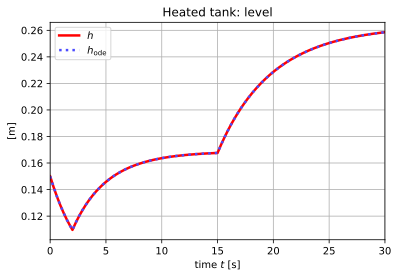

In [5]:
plt.plot(tm,h,linewidth=LW1,color=Cr1,label=r"$h$")
plt.plot(tm,hode,linewidth=LW1,color=Cb1,linestyle=LS2,label=r"$h_\mathrm{ode}$")
plt.title(r"Heated tank: level")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"[m]")
plt.legend()
plt.grid()
plt.xlim(0,30)
figfile = "HeatedTankSim-1.pdf"
plt.savefig(figpath+figfile)

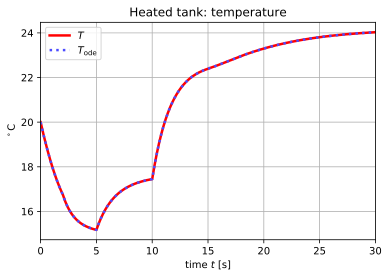

In [6]:
plt.plot(tm,T-273.15,linewidth=LW1,color=Cr1,label=r"$T$")
plt.plot(tm,Tode-273.15,linewidth=LW1,color=Cb1,linestyle=LS2,label=r"$T_\mathrm{ode}$")
plt.title(r"Heated tank: temperature")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"${}^\circ$C")
plt.legend()
plt.grid()
plt.xlim(0,30)
figfile = "HeatedTankSim-2.pdf"
plt.savefig(figpath+figfile)

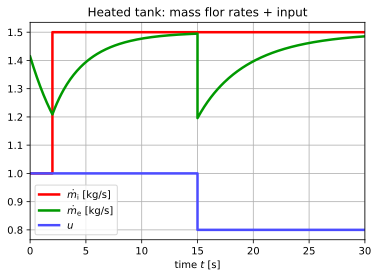

In [7]:
plt.plot(tm,mdi,linewidth=LW1,color=Cr1,label=r"$\dot{m}_\mathrm{i}$ [kg/s]")
plt.plot(tm,mde,linewidth=LW1,color=Cg1,label=r"$\dot{m}_\mathrm{e}$ [kg/s]")
plt.plot(tm,u,linewidth=LW1,color=Cb1,label=r"$u$")
plt.title(r"Heated tank: mass flor rates + input")
plt.xlabel(r"time $t$ [s]")
plt.legend()
plt.grid()
plt.xlim(0,30)
figfile = "HeatedTankSim-3.pdf"
plt.savefig(figpath+figfile)

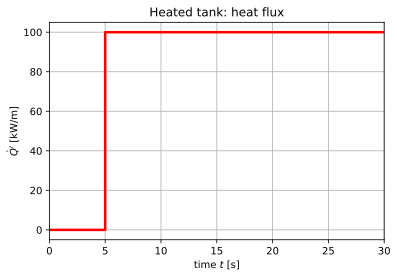

In [8]:
plt.plot(tm,Qdp/1e3,linewidth=LW1,color=Cr1,label=r"$\dot{Q}'$ [kW/m]")
plt.title(r"Heated tank: heat flux")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"$\dot{Q}'$ [kW/m]")
plt.grid()
plt.xlim(0,30)
figfile = "HeatedTankSim-4.pdf"
plt.savefig(figpath+figfile)

### Heated gas tank

#### Instantiating model from SimHeatedGasTank

#### Modelica code, file HeatedGasTank

In [9]:
%%writefile HeatedGasTank.mo
package HeatedGasTank
  // Package for simulating Heated gas Tank
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			October 26, 2015
  //			May 12, 2017
  //
  model SimHeatedGasTank
    // Simulation of Heated gas Tank
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 26, 2015
	//			May 12, 2017
	//
	// Instantiate model of Heated gas Tank (hgt)
	ModHeatedGasTank hgt;
	// Declaring variables
	// -- inputs
	Real _Qd "Added heat flow to gas tank, W";
	Real _pi "Influent gas pressure, Pa";
	Real _pa "Ambient pressure, Pa";
	Real _Ti "Influent gas temperature, K";
	// -- outputs
	output Real _p "Tank pressure, P";
	output Real _T "Heated tank temperature, K";
  // Equations
  equation
    // -- input values
	_Qd = if time < 120 then 0 else 2e2;
	_pi = if time < 180 then 10*hgt.ps else 8*hgt.ps;
	_pa = hgt.ps;
	_Ti = if time < 240 then 313.15 else 303.15;
	// -- injecting input functions to model inputs
	hgt.Qd = _Qd;
	hgt.pi = _pi;
	hgt.pa = _pa;
	hgt.Ti = _Ti;
	// -- outputs
	_p = hgt.p;
	_T = hgt.T;
  end SimHeatedGasTank;
  //
  model ModHeatedGasTank
    // Model of Heated gas Tank
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 26, 2015
	//			May 12, 2017
	//
	// Constants
	constant Real R = 8.31 "Ideal gas constant, J.K-1.mol-1";
	// Parameters
	parameter Real V = 50e-3 "Gas tank volume, m3";
	parameter Real M = 28 "Molar mass of gas, g.mol-1";
	parameter Real Ki = 3 "Influent valve constant, g/s";
	parameter Real ps = 1.03e5 "Scaling pressure, Pa";
	parameter Real Ke = 3 "Effluent valve constant, g/s";
	parameter Real Hhdd = 0 "Standard state specific enthalpy, J/g";
	parameter Real chp = 1 "Specific heat capacity at constant pressure, J.g-1.K-1";
	parameter Real Tdd = 298.15 "Standard state temperature, K";
	// Initial state parameters
	parameter Real p0 = 1.2*ps "Initial gas pressure, Pa";
	parameter Real T0 = 293.15 "Initial temperature, K";
	parameter Real m0 = p0*V*M/(R*T0) "Initial mass, g";
	parameter Real Hh0 = Hhdd + chp*(T0-Tdd) "Initial specific enthalpy, J/g";
	parameter Real U0 = m0*Hh0 - p0*V "Initial internal energy, J";
	// Declaring variables
	// -- states
	Real m(start = m0, fixed = true) "Mass in gas tank, kg";
	Real U(start = U0, fixed = true) "Internal energy in gas tank, J";
	// -- auxiliary variables
	Real mdi "Influent mass flow rate, g/s";
	Real mde "Effluent mass flow rate, g/s";
	Real Hdi "Influent enthalpy flow, J/s";
	Real Hde "Effluent enthalpy flow, J/s";
	Real p "Pressure in heated gas tank, Pa";
	Real n "Number of moles in heated gas tank, mol";
	Real T "Absolute temperature in heated gas tank, K";
	Real dpi "Influent valve pressure drop, Pa";
	Real dpe "Effluent valve pressure drop, Pa";
	Real Hh "Specific enthalpy in gas tank/of effluent, J/g";
	Real Hhi "Specific enthalpy of influent gas, J/g";
	// -- input variables
	input Real Qd "Heat added to gas tank, W";
    input Real pi "Influent pressure, Pa";
	input Real pa "Ambient pressure, Pa";
	input Real Ti "Influent temperature, K";
  // Equations constituting the model
  equation
	// Differential equations
	der(m) = mdi - mde;
	der(U) = Hdi - Hde + Qd;
	// Algebraic equations
	p*V = n*R*T;
	m = n*M;
	mdi = Ki*sqrt(dpi/ps);
	mde = Ke*sqrt(dpe/ps);
	dpi = pi - p;
	dpe = p - pa;
	U = m*Hh - p*V;
	Hh = Hhdd + chp*(T-Tdd);
	Hhi = Hhdd + chp*(Ti-Tdd);
	Hdi = mdi*Hhi;
	Hde = mde*Hh;
  end ModHeatedGasTank;
  // End package
end HeatedGasTank;

Writing HeatedGasTank.mo


In [10]:
hg = ModelicaSystem("HeatedGasTank.mo","HeatedGasTank.SimHeatedGasTank")

2017-08-07 17:19:55,514 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.4415fe34cd0e43f8af57c2bfd4e6b6cb


In [11]:
hg.setSimulationOptions(stopTime=400,stepSize=1.)
hg.simulate()
tm,T,Ti,p,pi,Qd = hg.getSolutions("time","_T","_Ti","_p","_pi","_Qd")

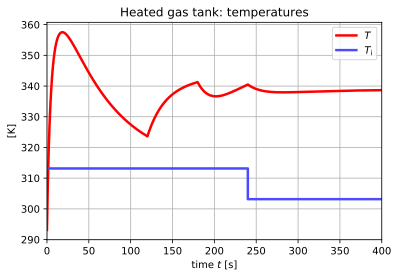

In [12]:
plt.plot(tm,T,linewidth=LW1,color=Cr1,label=r"$T$")
plt.plot(tm,Ti,linewidth=LW1,color=Cb1,label=r"$T_\mathrm{i}$")
plt.title(r"Heated gas tank: temperatures")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"[K]")
plt.legend()
plt.grid()
plt.xlim(0,400)
figfile = "heatedGasTankSim-1.pdf"
plt.savefig(figpath+figfile)

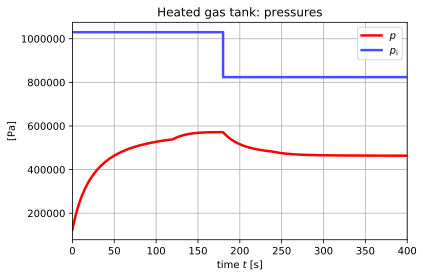

In [13]:
plt.plot(tm,p,linewidth=LW1,color=Cr1,label=r"$p$")
plt.plot(tm,pi,linewidth=LW1,color=Cb1,label=r"$p_\mathrm{i}$")
plt.title(r"Heated gas tank: pressures")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"[Pa]")
plt.legend()
plt.grid()
plt.xlim(0,400)
figfile = "heatedGasTankSim-2.pdf"
plt.savefig(figpath+figfile)

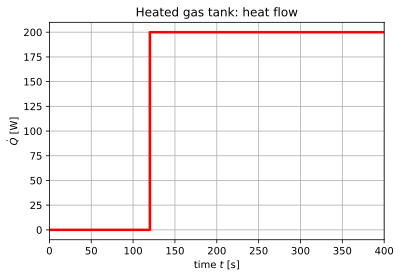

In [14]:
plt.plot(tm,Qd,linewidth=LW1,color=Cr1,label=r"$\dot{Q}$")
plt.title(r"Heated gas tank: heat flow")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"$\dot{Q}$ [W]")
plt.grid()
plt.xlim(0,400)
figfile = "heatedGasTankSim-3.pdf"
plt.savefig(figpath+figfile)

### Heater rod diffusion

#### Modelica code, file MetalRod

In [15]:
%%writefile MetalRod.mo
package MetalRod
  // Package for simulating temperature diffusion in metal rod
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			October 29, 2015
  //			May 12, 2017
  //
  model SimCompareMetalRod
	// Simulation and comparison of Temperature diffusion in metal rod
	// author:	Bernt Lie
	//			University of Southeast Norway
	//			October 29, 2015
	//			May 12, 2017
	//
	// Instantiate model
	ModMetalRod mr10(N=10), mr30(N=30), mr90(N=90), mr300(N=300);
	// Declaring variables
	// -- inputs
	Real _Tp "Temperature of heated plate, K";
	Real _Ta "Temperature of air, K";
	Real _h "Heat transfer coefficient, J.m-2.K-1";
	// -- outputs
	output Real _TL10, _TL30, _TL90, _TL300;
  // Equations
  equation
  // -- setting input values
	_Tp = if time < 100 then 293.15 else 323.15;
	_Ta = if time < 750 then 293.15 else 298.15;
	_h = if time < 500 then 3 else 30;
	// -- injecting inputs to underlying model
	mr10.Tp = _Tp;
	mr10.Ta = _Ta;
	mr10.h = _h;
	mr30.Tp = _Tp;
	mr30.Ta = _Ta;
	mr30.h = _h;
	mr90.Tp = _Tp;
	mr90.Ta = _Ta;
	mr90.h = _h;
	mr300.Tp = _Tp;
	mr300.Ta = _Ta;
	mr300.h = _h;
	// -- outputs
	_TL10 = mr10.T[mr10.N];
	_TL30 = mr30.T[mr30.N];
	_TL90 = mr90.T[mr90.N];
	_TL300 = mr300.T[mr300.N];
  end SimCompareMetalRod;
  //
  model SimMetalRod
	// Simulation of Temperature diffusion in metal rod
	// author:	Bernt Lie
	//			University of Southeast Norway
	//			October 29, 2015
	//			May 12, 2017
	//
	// Instantiate model
	ModMetalRod mr;
	// Declaring variables
	// -- inputs
	Real _Tp "Temperature of heated plate, K";
	Real _Ta "Temperature of air, K";
	Real _h "Heat transfer coefficient, J.m-2.K-1";
	// -- outputs
	output Real _TL "Temperature of metal rod at x=L, K";
  // Equations
  equation
    // -- setting input values
	_Tp = if time < 100 then 293.15 else 323.15;
	_Ta = if time < 750 then 293.15 else 298.15;
	_h = if time < 500 then 3 else 30;
	// -- injecting inputs to underlying model
	mr.Tp = _Tp;
	mr.Ta = _Ta;
	mr.h = _h;
	// -- output
	_TL = mr.T[mr.N];
  end SimMetalRod; 
  // 
  model ModMetalRod
    // Underlying model for Temperature diffusion in metal rod
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 29, 2015
	//			May 12, 2017
	//
	// Parameters
	parameter Real L = 4 "Pipe length, dm";
	parameter Real A = 2 "Pipe cross sectional area, dm2";
	parameter Real rho = 7.8 "Metal density, kg/L";
	parameter Integer N = 10 "Number of slices in pipe, -";
	parameter Real dx = L/N "Slice length, dm";
	parameter Real V = dx*A "Slice volume, L";
	parameter Real m = rho*V "Slice mass, kg";
	parameter Real chp = 450 "Metal specific heat capacity, J.kg-1.K-1";
	parameter Real Tdd = 293.15 "Standard state temperature of metal, K";
	parameter Real k = 45 "Thermal conductivity of metal, W.m-1.K-1";
	// Initial state parameters
	parameter Real T0 = 293.15 "Initial temperature in slices, K";
	parameter Real Hh0 = chp*(T0-Tdd) "Initial specific enthalpy in slices, J/kg";
	parameter Real U0 = m*Hh0 "Initial internal energy of slices, J";
	parameter Real oneN[N] = ones(N);
    // Declaring variables
	// -- states
	Real U[N](each start = U0, each fixed = true) "Internal energy in each slice, J";
	// -- auxiliary variables
	Real Hh[N] "Specific enthalpy in slices, J/kg";
	Real T[N] "Temperature in slices, K";
	Real Qd[N] "Heat flow through slices, W";
	Real Qdpp[N+1] "Heat flux through slices, W";
	// -- input variables
    input Real Tp "Temperature of heated plate, K"; 
	input Real Ta "Temperature of air, K";
	input Real h "Heat transfer coefficient depending on air velocity, W.m-2.K-1";
  // Equations constituting the model
  equation
  // Differential equations
	der(U[:]) = Qd[:];
	// Algebraic equations
	U[:] = m*Hh[:];
	Hh[:] = chp*(T[:]-Tdd*oneN[:]);
	Qd[:] = (Qdpp[1:N] - Qdpp[2:N+1])*A;
	Qdpp[1] = -k*(T[1]-Tp)/(2*dx);
	Qdpp[2] = -k*(T[2]-Tp)/(2*dx);
	Qdpp[3:N] = -k*(T[3:N] - T[1:N-2])/(2*dx);
	Qdpp[N+1] = h*(T[N]-Ta);
  end ModMetalRod;
  // End package
end MetalRod;

Writing MetalRod.mo


#### Instantiating model from SimMetalRod

In [16]:
hr = ModelicaSystem("MetalRod.mo","MetalRod.SimMetalRod")

2017-08-07 17:19:59,930 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.eac9179d6718403f9cb71c2e03fc69d2


In [17]:
hr.setSimulationOptions(stopTime=1800,stepSize=9)
hr.simulate()
tm,TL,Tp,Ta,h = hr.getSolutions("time","_TL","_Tp","_Ta","_h")
T0,T1,T2,T3,T4,T5 = hr.getSolutions("mr.T0","mr.T[1]","mr.T[2]","mr.T[3]","mr.T[4]","mr.T[5]")
T6,T7,T8,T9,T10 = hr.getSolutions("mr.T[6]","mr.T[7]","mr.T[8]","mr.T[9]","mr.T[10]")

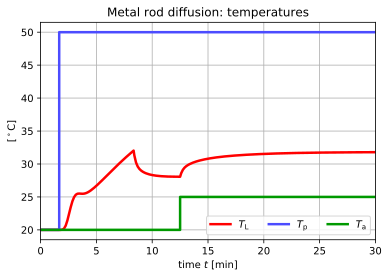

In [18]:
plt.plot(tm/60,TL-273.15,linewidth=LW1,color=Cr1,label=r"$T_\mathrm{L}$")
plt.plot(tm/60,Tp-273.15,linewidth=LW1,color=Cb1,label=r"$T_\mathrm{p}$")
plt.plot(tm/60,Ta-273.15,linewidth=LW1,color=Cg1,label=r"$T_\mathrm{a}$")
plt.title(r"Metal rod diffusion: temperatures")
plt.xlabel(r"time $t$ [min]")
plt.ylabel(r"[${}^\circ$C]")
plt.legend(ncol=3)
plt.grid()
plt.xlim(0,30)
figfile = "metalRodSim-1.pdf"
plt.savefig(figpath+figfile)

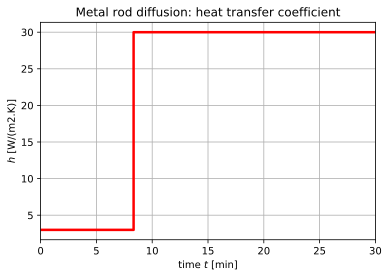

In [19]:
plt.plot(tm/60,h,linewidth=LW1,color=Cr1,label=r"$h$")
plt.title(r"Metal rod diffusion: heat transfer coefficient")
plt.xlabel(r"time $t$ [min]")
plt.ylabel(r"$h$ [W/(m2.K)]")
plt.grid()
plt.xlim(0,30)
figfile = "metalRodSim-2.pdf"
plt.savefig(figpath+figfile)

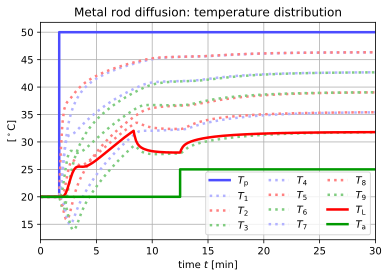

In [20]:
plt.plot(tm/60,Tp-273.15,linewidth=LW1,color=Cb1,label=r"$T_\mathrm{p}$")
plt.plot(tm/60,T1-273.15,linewidth=LW1,color=Cb2,ls=LS2,label=r"$T_1$")
plt.plot(tm/60,T2-273.15,linewidth=LW1,color=Cr2,ls=LS2,label=r"$T_2$")
plt.plot(tm/60,T3-273.15,linewidth=LW1,color=Cg2,ls=LS2,label=r"$T_3$")
plt.plot(tm/60,T4-273.15,linewidth=LW1,color=Cb2,ls=LS2,label=r"$T_4$")
plt.plot(tm/60,T5-273.15,linewidth=LW1,color=Cr2,ls=LS2,label=r"$T_5$")
plt.plot(tm/60,T6-273.15,linewidth=LW1,color=Cg2,ls=LS2,label=r"$T_6$")
plt.plot(tm/60,T7-273.15,linewidth=LW1,color=Cb2,ls=LS2,label=r"$T_7$")
plt.plot(tm/60,T8-273.15,linewidth=LW1,color=Cr2,ls=LS2,label=r"$T_8$")
plt.plot(tm/60,T9-273.15,linewidth=LW1,color=Cg2,ls=LS2,label=r"$T_9$")
plt.plot(tm/60,TL-273.15,linewidth=LW1,color=Cr1,label=r"$T_\mathrm{L}$")
plt.plot(tm/60,Ta-273.15,linewidth=LW1,color=Cg1,label=r"$T_\mathrm{a}$")
plt.title(r"Metal rod diffusion: temperature distribution")
plt.xlabel(r"time $t$ [min]")
plt.ylabel(r"[${}^\circ$C]")
plt.legend(ncol=3)
plt.grid()
plt.xlim(0,30)
figfile = "metalRodSim-3.pdf"
plt.savefig(figpath+figfile)

#### Instantiating model from SimCompareMetalRod

In [21]:
hr = ModelicaSystem("MetalRod.mo","MetalRod.SimCompareMetalRod")

2017-08-07 17:20:05,511 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.37520736203b452caba1094955f508f0


In [22]:
hr.setSimulationOptions(stopTime=1800,stepSize=9)
hr.simulate()
tm,TL10,TL30,TL90,TL300,Ta,Tp = hr.getSolutions("time","_TL10","_TL30","_TL90","_TL300","_Ta","_Tp")

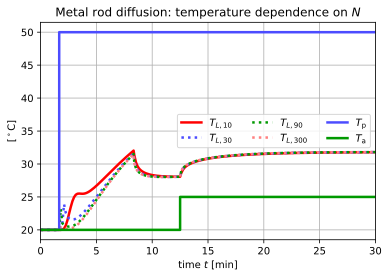

In [23]:
plt.plot(tm/60,TL10-273.15,linewidth=LW1,color=Cr1,label=r"$T_{L,10}$")
plt.plot(tm/60,TL30-273.15,linewidth=LW1,color=Cb1,ls=LS2,label=r"$T_{L,30}$")
plt.plot(tm/60,TL90-273.15,linewidth=LW1,color=Cg1,ls=LS2,label=r"$T_{L,90}$")
plt.plot(tm/60,TL300-273.15,linewidth=LW1,color=Cr2,ls=LS2,label=r"$T_{L,300}$")
plt.plot(tm/60,Tp-273.15,linewidth=LW1,color=Cb1,label=r"$T_\mathrm{p}$")
plt.plot(tm/60,Ta-273.15,linewidth=LW1,color=Cg1,label=r"$T_\mathrm{a}$")
plt.title(r"Metal rod diffusion: temperature dependence on $N$")
plt.xlabel(r"time $t$ [min]")
plt.ylabel(r"[${}^\circ$C]")
plt.legend(ncol=3)
plt.grid()
plt.xlim(0,30)
figfile = "metalRodSim-4.pdf"
plt.savefig(figpath+figfile)

### Cooled liquid reactor

#### Modelica code, file CooledLiquidReactor

In [24]:
%%writefile CooledLiquidReactor.mo
package CooledLiquidReactor
  // Package for simulating Cooled Liquid Reactor
  // author: 	Bernt Lie
  //			University of Southeast Norway
  //			October 27, 2015
  //			May 12, 2017
  //
  model SimCooledLiquidReactor
    // Simulation of Cooled Liquid Reactor
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 27, 2015
	//			May 12, 2017
	//
	// Instantiate model of Cooled Liquid Reactor (clr)
	ModCooledLiquidReactor clr;
	ModCooledLiquidReactorODE clrODE;
	// Declaring variables
	// -- inputs
	Real _Vd "Volumetric flow rate through reactor, L/s";
	Real _cAi "Influent molar concentration of A, mol/s";
	Real _Ti "Influent temperature, K";
	Real _Qd "Added 'heat' to reactor, kW";
	// -- outputs
	output Real _cA "Molar concentration of A, mol/L";
	output Real _cB "Molar concentration of B, mol/L";
	output Real _T "Reactor temperature, K";
	output Real _cA_ODE "Molar concentration of A, mol/L";
	output Real _cB_ODE "Molar concentration of B, mol/L";
	output Real _T_ODE "Reactor temperature, K";
  // Equations
  equation
    // -- input values
	_Vd = if time < 80 then 2 else 3;
	_cAi = if time < 60 then 3 else 4;
	_Ti = if time < 40 then 283.15 else 278.15;
	_Qd = if time < 10 then 0 else -50;
	// -- injecting input functions to model inputs
	clr.Vd = _Vd;
	clr.cAi = _cAi;
	clr.Ti = _Ti;
	clr.Qd = _Qd;
	clrODE.Vd = _Vd;
	clrODE.cAi = _cAi;
	clrODE.Ti = _Ti;
	clrODE.Qd = _Qd;
	// -- outputs
	_cA = clr.cA;
	_cB = clr.cB;
	_T = clr.T;
	_cA_ODE = clrODE.cA;
	_cB_ODE = clrODE.cB;
	_T_ODE = clrODE.T;
  end SimCooledLiquidReactor;
  //
  model ModCooledLiquidReactor
    // Model of Cooled Liquid Reactor
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 27, 2015
	//			May 12, 2017
	//
	// Parameters
	parameter Real V = 15 "Reactor volume, L";
	parameter Real rho = 1 "Liquid density, kg/L";
	parameter Real a = 2 "Stoichiometric constant, -";
	parameter Real k0 = 0.1 "Pre-exponential factor, ...";
	parameter Real EdR = 1e3 "Activation temperature, K";
	parameter Real HtAdd = 100 "Molar enthalpy of A at std cond, kJ/mol";
	parameter Real HtBdd = -150 "Molar enthalpy of B at std cond, kJ/mol";
	parameter Real HhSdd = 0 "Specific enthalpy of solvent at std cond, kJ/kg";
	parameter Real cptA = 50e-3 "Molar heat capacity of A, kJ.mol-1.K-1";
	parameter Real cptB = 100e-3 "Molar heat capacity of B, kJ.mol-1.K-1";
	parameter Real cphS = 4.2 "Specific heat capacity of solvent, kJ.kg-1.K-1";
	parameter Real Tdd = 293.15 "Temperature in std state, K";
	parameter Real pdd = 1.01e5 "Pressure in std state, Pa";
	
	// Initial state parameters
	parameter Real nA0 = 2 "Initial number of moles of A, mol";
	parameter Real nB0 = 0 "Initial number of moles of B, mol";
	parameter Real mS = rho*V "Mass of solvent, kg";
	parameter Real T0 = 288.15 "Initial temperature, K";
	parameter Real HtAp0 = HtAdd + cptA*(T0-Tdd) "Initial molar enthalpy of A, kJ/mol";
	parameter Real HtBp0 = HtBdd + cptB*(T0-Tdd) "Initial molar enthalpy of B, kJ/mol";
	parameter Real HhSp0 = HhSdd + cphS*(T0-Tdd) "Initial specific enthalpy of solvent, kJ/kg";
	parameter Real HAp0 = nA0*HtAp0 "Initial enthalpy of A, kJ";
	parameter Real HBp0 = nB0*HtBp0 "Initial enthalpy of B, kJ";
	parameter Real HSp0 = mS*HhSp0 "Initial enthalpy of solvent, kJ";
	parameter Real H0 = HAp0 + HBp0 + HSp0 "Initial total enthalpy of ideal solution, kJ";
	parameter Real U0 = H0 - pdd*V "Initial internal energy, kJ";
	// Declaring variables
	// -- states
	Real nA(start = nA0, fixed = true) "Initializing amount of A in reactor, mol";
	Real nB(start = nB0, fixed = true) "Initializing amount of B in reactor, mol";
	Real U(start = U0, fixed = true) "Initializing internal energy in reactor, kJ";
	// -- auxiliary variables
	Real ndAi "Influent molar flow rate of A, mol/s";
	Real ndAe "Effluent molar flow rate of A, mol/s";
	Real ndAg "Molar rate of generation of A, mol/s";
	Real ndBi "Influent molar flow rate of B, mol/s";
	Real ndBe "Effluent molar flow rate of B, mol/s";
	Real ndBg "Molar rate of generation of B, mol/s";
	Real mdSi "Influent mass flow rate of solvent, kg/s";
	Real mdSe "Effluent mass flow rate of solvent, kg/s";
	Real Hdi "Influent enthalpy flow rate, kJ/s";
	Real Hde "Effluent enthalpy flow rate, kJ/s";
	Real cA "Molar concentration of A, mol/L";
	Real cB "Molar concentration of B, mol/L";
	Real r "Rate of reaction, mol/(L.s)";
	Real k "Reaction 'constant', ...";
	Real T "Reactor temperature, K";
	Real H "Reactor enthalpy, kJ";
	Real HAp "Enthalpy of pure A, kJ";
	Real HBp "Enthalpy of pure B, kJ";
	Real HSp "Enthalpy of pure solvent, kJ";
	Real HtAp "Molar enthalpy of pure A, kJ/mol";
	Real HtBp "Molar enthalpy of pure B, kJ/mol";
	Real HhSp "Specific enthalpy of pure solvent, kJ/kg";
	Real HdApi "Influent enthalpy flow of pure A,kJ/s";
	Real HdBpi "Influent enthalpy flow of pure B, kJ/s";
	Real HdSpi "Influent enthalpy flow of pure solvent, kJ/s";
	Real HtApi "Influent molar enthalpy of pure A, kJ/mol";
	Real HtBpi "Influent molar enthalpy of pure B, kJ/mol";
	Real HhSpi "Influent specific enthalpy of solvent, kJ/kg";
	Real HdApe "Effluent enthalpy flow of pure A, kJ/s";
	Real HdBpe "Effluent enthalpy flow of pure B, kJ/s";
	Real HdSpe "Effluent enthalpy flow of pure solvent, kJ/s";
	// -- input variables
	input Real Vd "Volumetric flow rate through reactor, L/s";
    input Real cAi "Influent molar concentration of A, mol/L";
	input Real Ti "Influent temperature, K";
	input Real Qd "Added 'heat', kW";
  // Equations constituting the model
  equation
	// Differential equations
	der(nA) = ndAi - ndAe + ndAg;
	der(nB) = ndBi - ndBe + ndBg;
	der(U) = Hdi - Hde + Qd;
	// Algebraic equations
	nA = cA*V;
	nB = cB*V;
	ndAi = cAi*Vd;
	ndBi = 0;
	mdSi = rho*Vd;
	ndAe = cA*Vd;
	ndBe = cB*Vd;
	mdSe = mdSi;
	ndAg = -a*r*V;
	ndBg = r*V;
	r = k*cA^a;
	k = k0*exp(-EdR/T);
	U = H-pdd*V;
	H = HAp + HBp + HSp;
	HAp = nA*HtAp;
	HBp = nB*HtBp;
	HSp = mS*HhSp;
	HtAp = HtAdd + cptA*(T-Tdd);
	HtBp = HtBdd + cptB*(T-Tdd);
	HhSp = HhSdd + cphS*(T-Tdd);
	Hdi = HdApi + HdBpi + HdSpi;
	HdApi = ndAi*HtApi;
	HdBpi = ndBi*HtBpi;
	HdSpi = mdSi*HhSpi;
	HtApi = HtAdd + cptA*(Ti-Tdd);
	HtBpi = 0;
	HhSpi = HhSdd + cphS*(Ti-Tdd);
	Hde = HdApe + HdBpe + HdSpe;
	HdApe = ndAe*HtAp;
	HdBpe = ndBe*HtBp;
	HdSpe = mdSe*HhSp;
  end ModCooledLiquidReactor;
  //
  model ModCooledLiquidReactorODE
    // Model of Cooled Liquid Reactor
    // author: 	Bernt Lie
    //			University of Southeast Norway
    //			October 27, 2015
	//			May 12, 2017
	//
	// Parameters
	parameter Real V = 15 "Reactor volume, L";
	parameter Real rho = 1 "Liquid density, kg/L";
	parameter Real a = 2 "Stoichiometric constant, -";
	parameter Real k0 = 0.1 "Pre-exponential factor, ...";
	parameter Real EdR = 1e3 "Activation temperature, K";
	parameter Real HtAdd = 300 "Molar enthalpy of A at std cond, kJ/mol";
	parameter Real HtBdd = -400 "Molar enthalpy of B at std cond, kJ/mol";
	parameter Real HhSdd = 0 "Specific enthalpy of solvent at std cond, kJ/kg";
	parameter Real cptA = 50e-3 "Molar heat capacity of A, kJ.mol-1.K-1";
	parameter Real cptB = 100e-3 "Molar heat capacity of B, kJ.mol-1.K-1";
	parameter Real cphS = 4.2 "Specific heat capacity of solvent, kJ.kg-1.K-1";
	parameter Real Tdd = 293.15 "Temperature in std state, K";
	
	// Initial state parameters
	parameter Real nA0 = 2 "Initial number of moles of A, mol";
	parameter Real nB0 = 0 "Initial number of moles of B, mol";
	parameter Real cA0 = nA0/V "Initial molar concentration of A, mol/L";
	parameter Real cB0 = nB0/V "Initial molar concentration of B, mol/L";
	parameter Real T0 = 288.15 "Initial temperature, K";
	// Declaring variables
	// -- states
	Real cA(start = cA0, fixed = true) "Initializing concentration of A in reactor, mol/L";
	Real cB(start = cB0, fixed = true) "Initializing concentration of B in reactor, mol/L";
	Real T(start = T0, fixed = true) "Initializing temperature in reactor, K";
	// -- auxiliary variables
	Real r "Rate of reaction, mol/(L.s)";
	Real k "Reaction 'constant', ...";
	Real dHtr "Molar enthalpy of reaction, kJ/mol";
	// -- input variables
	input Real Vd "Volumetric flow rate through reactor, L/s";
    input Real cAi "Influent molar concentration of A, mol/L";
	input Real Ti "Influent temperature, K";
	input Real Qd "Added 'heat', kW";
  // Equations constituting the model
  equation
	// Differential equations
	V*der(cA) = cAi*Vd - cA*Vd - a*r*V;
	V*der(cB) = -cB*Vd + r*V;
	(cA*V*cptA + cB*V*cptB + rho*V*cphS)*der(T) = (cAi*Vd*cptA+rho*Vd*cphS)*(Ti-T) -dHtr*r*V + Qd;
	// Algebraic equations
	r = k*cA^a;
	k = k0*exp(-EdR/T);
	dHtr = HtBdd - a*HtAdd + (cptB-a*cptA)*(T-Tdd);
  end ModCooledLiquidReactorODE;
  // End package
end CooledLiquidReactor;

Writing CooledLiquidReactor.mo


#### Instantiating model from SimCooledLiquidReactor

In [25]:
lr = ModelicaSystem("CooledLiquidReactor.mo","CooledLiquidReactor.SimCooledLiquidReactor")

2017-08-07 17:20:13,719 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.dietmarw.port.21046e8a9a8d48118bb7ac02b7ec5632


In [26]:
lr.setSimulationOptions(stopTime=120,stepSize=0.5)
lr.simulate()
tm,cA,cB,cAi,T,Ti,Qd,Vd = lr.getSolutions("time","_cA","_cB","_cAi","_T","_Ti","_Qd","_Vd")

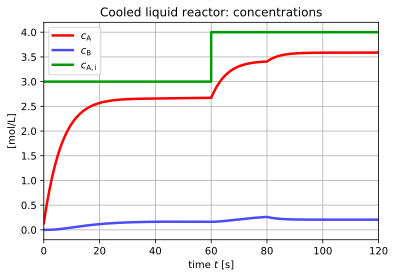

In [27]:
plt.plot(tm,cA,linewidth=LW1,color=Cr1,label=r"$c_\mathrm{A}$")
plt.plot(tm,cB,linewidth=LW1,color=Cb1,label=r"$c_\mathrm{B}$")
plt.plot(tm,cAi,linewidth=LW1,color=Cg1,label=r"$c_\mathrm{A,i}$")
plt.title(r"Cooled liquid reactor: concentrations")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"[mol/L]")
plt.legend()
plt.grid()
plt.xlim(0,120)
figfile = "cooledLiquidReactorSim-1.pdf"
plt.savefig(figpath+figfile)

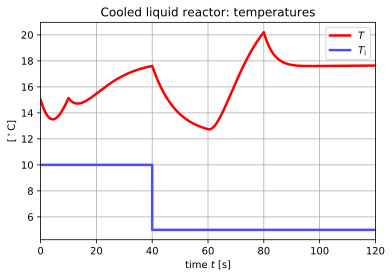

In [28]:
plt.plot(tm,T-273.15,linewidth=LW1,color=Cr1,label=r"$T$")
plt.plot(tm,Ti-273.15,linewidth=LW1,color=Cb1,label=r"$T_\mathrm{i}$")
plt.title(r"Cooled liquid reactor: temperatures")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"[${}^\circ$C]")
plt.legend()
plt.grid()
plt.xlim(0,120)
figfile = "cooledLiquidReactorSim-2.pdf"
plt.savefig(figpath+figfile)

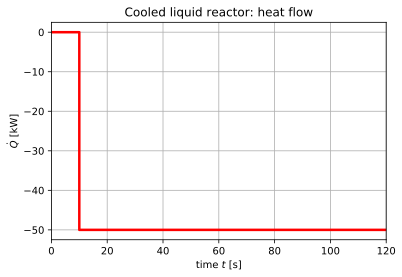

In [29]:
plt.plot(tm,Qd,linewidth=LW1,color=Cr1,label=r"$\dot{Q}$")
plt.title(r"Cooled liquid reactor: heat flow")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"$\dot{Q}$ [kW]")
plt.grid()
plt.xlim(0,120)
figfile = "cooledLiquidReactorSim-3.pdf"
plt.savefig(figpath+figfile)

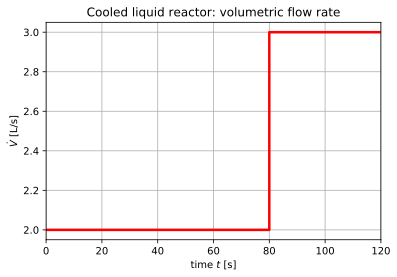

In [30]:
plt.plot(tm,Vd,linewidth=LW1,color=Cr1,label=r"$\dot{V}$")
plt.title(r"Cooled liquid reactor: volumetric flow rate")
plt.xlabel(r"time $t$ [s]")
plt.ylabel(r"$\dot{V}$ [L/s]")
plt.grid()
plt.xlim(0,120)
figfile = "cooledLiquidReactorSim-4.pdf"
plt.savefig(figpath+figfile)